**Problem Statment** : To predict whether the cancer is benign or malignant

About Dataset
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

- 1) ID number
- 2) Diagnosis (M = malignant, B = benign)
- 3-32)

Ten real-valued features are computed for each cell nucleus:

- a) radius (mean of distances from center to points on the perimeter)
- b) texture (standard deviation of gray-scale values)
- c) perimeter
- d) area
- e) smoothness (local variation in radius lengths)
- f) compactness (perimeter^2 / area - 1.0)
- g) concavity (severity of concave portions of the contour)
- h) concave points (number of concave portions of the contour)
- i) symmetry
- j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

**Importing the necesary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
plt.style.use('ggplot')

Loading the dataset

In [2]:
data = pd.read_csv('data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Checking the information of the dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

From the above it is observed all the dependent variable are numeric while the independent feature (diagnosis) which will be label encoded. And also the 32rd feature is completely empty so it has to be dropped.

**Dropping the 'Unnamed: 32'columns because all the values are null**

In [4]:
data = data.drop(columns = 'Unnamed: 32')

Checking for the null values present in the dataset

In [5]:
data.isnull().values.any()

False

From the above, it has shown that there are no null values present in the dataset

checking for the duplicate values present in the data

In [6]:
data.duplicated().values.any()

False

From the above, there are no duplicate values present

Checking for the distribution of the independent column ('diagnosis') 

B    357
M    212
Name: diagnosis, dtype: int64


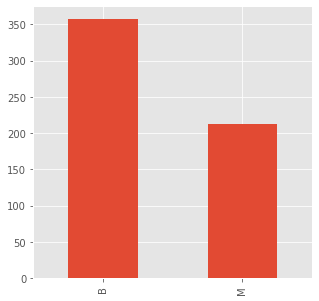

In [7]:
plt.figure(figsize=(5,5))
print(data['diagnosis'].value_counts())
data['diagnosis'].value_counts().plot(kind='bar')
plt.show()

From the above, The frequency of the benign is more than that of the malignant, which will affect the training of the model.

- Benign    -       62.74%
- Malignant -      37.25%

So, the benign data will be reduced so that it has the samples as the malignant class

In [8]:
benign = data[data['diagnosis'] == 'B'].iloc[0:250 , :]
malignant = data[data['diagnosis'] == 'M']

In [9]:
data = pd.concat([benign , malignant])

Checking the new distribution of the dependent variable

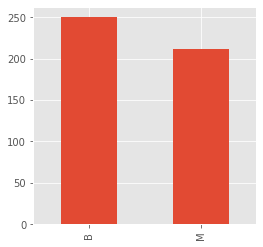

In [10]:
plt.figure(figsize=(4,4))
data['diagnosis'].value_counts().plot(kind='bar')
plt.show()

From the above, the distribution is more balanced

The index columns is not needed, so it will removed

In [11]:
data = data.drop(columns = 'id')

Encoding the dependent variable, where Malignant = 1, Benign = 0

In [12]:
diag_map = {'M': 1, 'B' : 0}

In [13]:
data['diagnosis'] = data['diagnosis'].map(diag_map)

This problem is a classification problem, so we have to split the variables into the dependent and independent variable and also splitting them into train and test set

In [14]:
X = data.drop(columns = 'diagnosis')
y = data['diagnosis']

X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=.3, random_state = 23, stratify=y)

Applying the robust scaler to scale the data, so as to handle the outlier present in the data

In [15]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Setting up the all the needed algorithms to build the model.

In [16]:
algorithms = {
    'Logistic Regression' : {
        'model' : LogisticRegression(),
        'params' : {
                'C'       : [i for i in range(1,6)],
                'fit_intercept' : [True, False]
        }
    },
    
    'SVM' : {
        'model': SVC(),
        'params': {
            'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
            'C'      : [i for i in range(1,6)],
            'degree' : [i for i in range(2,6)]
        }
    }, 

    'Random Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)],
            'criterion' : ['gini', 'entropy']
        }
    },
    'Extra Tree Classifier' : {
        'model' : ExtraTreesClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)],
            'criterion' : ['gini', 'entropy']
        }
    },
    
    'XGBoost' : {
        'model' : XGBClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)]
        }
    },
    
    'Decision Tree' : {
        'model' : DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random']
        }
    },
    
    'KNN' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : [i for i in range(3, 9, 2)],
            'weights' : ['uniform', 'distance']
            
        }
    },
    
    'Ada Boost' : {
        'model' : AdaBoostClassifier(),
        'params' : {
            'n_estimators': [i for i in range(40, 120, 20)],
            'algorithm' : ['SAMME', 'SAMME.R'],
        }
    },
    
    'Naive Bayes' : {
        'model' : GaussianNB(), 
        'params' :{}
    }
    
}

In [17]:
accuracies = []

for model_name, params in algorithms.items():
    grid = GridSearchCV(params['model'], param_grid = params['params'], verbose=1)
    
    grid.fit(X_train, y_train)
    accuracies.append({'model' : model_name, 'Best Score' : grid.best_score_, 'best h-parameter': grid.best_params_})
    

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.8s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jeremiah\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [18]:
acc = pd.DataFrame(accuracies)
acc.sort_values('Best Score', ascending =False)

,model,Best Score,best h-parameter
0,Logistic Regression,0.984567,"{'C': 1, 'fit_intercept': True}"
1,SVM,0.981490,"{'C': 2, 'degree': 2, 'kernel': 'rbf'}"
7,Ada Boost,0.978365,"{'algorithm': 'SAMME', 'n_estimators': 100}"
3,Extra Tree Classifier,0.975288,"{'criterion': 'entropy', 'n_estimators': 150}"
2,Random Forest,0.966058,"{'criterion': 'entropy', 'n_estimators': 150}"
6,KNN,0.962885,"{'n_neighbors': 7, 'weights': 'uniform'}"
5,Decision Tree,0.950625,"{'criterion': 'entropy', 'splitter': 'best'}"
4,XGBoost,0.950577,{'n_estimators': 100}
8,Naive Bayes,0.950577,{}


From the above, Logistic regression and svm has the highest accuracy

In [29]:
logreg = LogisticRegression(C = 1, fit_intercept = True)
logreg.fit(X_train , y_train)

pred = logreg.predict(X_test)
#Checking the accuracy of the train and test set

train_pred = logreg.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, pred)

print(f'Train Accuracy = {train_acc}')
print(f'Test Accuracy = {test_acc}')

Train Accuracy = 0.9907120743034056
Test Accuracy = 0.9640287769784173


In [41]:
svm = SVC( C = 2, degree = 2, kernel= 'rbf')
svm.fit(X_train , y_train)

pred = svm.predict(X_test)

#Checking the accuracy of the train and test set
train_pred = svm.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, pred)

print(f'Train Accuracy = {train_acc}')
print(f'Test Accuracy = {test_acc}')

Train Accuracy = 0.9907120743034056
Test Accuracy = 0.9712230215827338


From the above,It has been confirmed that SVM has The highest accuracy. **With an accuracy of 97.12**

checking the confusion matrix of the model

In [42]:
cm = confusion_matrix(y_test, pred)
cm

array([[74,  1],
       [ 3, 61]], dtype=int64)

In [45]:
cr = classification_report(y_test, pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        75
           1       0.98      0.95      0.97        64

    accuracy                           0.97       139
   macro avg       0.97      0.97      0.97       139
weighted avg       0.97      0.97      0.97       139



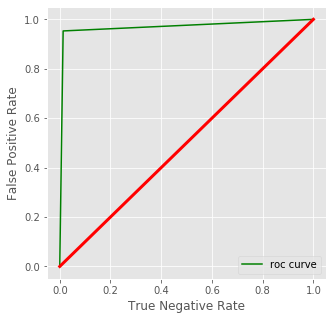

In [56]:
fpr, tpr, threshold = roc_curve(y_test, pred)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='roc curve', color='green')
plt.xlabel('True Negative Rate')
plt.plot([0,1], [0,1], color='red', linewidth='3')
plt.ylabel('False Positive Rate')
plt.legend()
plt.show()